Import package

In [1]:
import tensorflow 
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

Dataset

In [2]:
data_path = "C:\AI4H\Dataset1"
num_pneumonia    = len(os.listdir(os.path.join(data_path, 'PNEUMONIA')))
num_normal       = len(os.listdir(os.path.join(data_path, 'NORMAL')))
num_tuberculosis = len(os.listdir(os.path.join(data_path, 'TUBERCULOSIS')))
print(f"PNEUMONIA = {num_pneumonia}")
print(f"NORMAL = {num_normal}")
print(f"TUBERCULOSIS = {num_tuberculosis}")
print(f"Dataset = {num_normal+num_pneumonia+num_tuberculosis}")

PNEUMONIA = 3987
NORMAL = 3708
TUBERCULOSIS = 1854
Dataset = 9549


LABEL

In [3]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("C:\AI4H\Dataset1")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("C:\AI4H\Dataset1/"+img)))
    for i in path:
        image = cv2.imread("C:\AI4H\Dataset1/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['PNEUMONIA', 'NORMAL', 'Tuberculosis']


In [4]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 1 0]


X_train and Y_train

In [5]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(5729, 128, 128, 3) (3820, 128, 128, 3)


MODEL

In [ ]:
model_d = tf.keras.applications.DenseNet201(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(128,128,3),
    pooling="avg",
    classes=3,
    #classifier_activation="softmax",
)
x=model_d.output
preds=Dense(3,activation='softmax')(x)

In [ ]:
model=Model(inputs=model_d.input,outputs=preds)

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
checkpoint = ModelCheckpoint('DenseNet201_01_test1.h5', verbose=1, save_best_only=True)
Early = EarlyStopping(monitor='val_accuracy', patience=8, mode="max",verbose=1)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2, brightness_range=(0.4,0.9))

datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=10),
               steps_per_epoch=xtrain.shape[0] //10,
               epochs=15,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtest, ytest))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
results = model.evaluate(xtest, ytest, batch_size=10)
print("test loss, test acc:", results)

382/382 [==============================] - 38s 67ms/step - loss: 0.0864 - accuracy: 0.9704
test loss, test acc: [0.08643607795238495, 0.9704188704490662]


In [17]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 3820 	accurately-predicted-data: 3707 	 wrongly-predicted-data:  113
Accuracy: 97.042 %


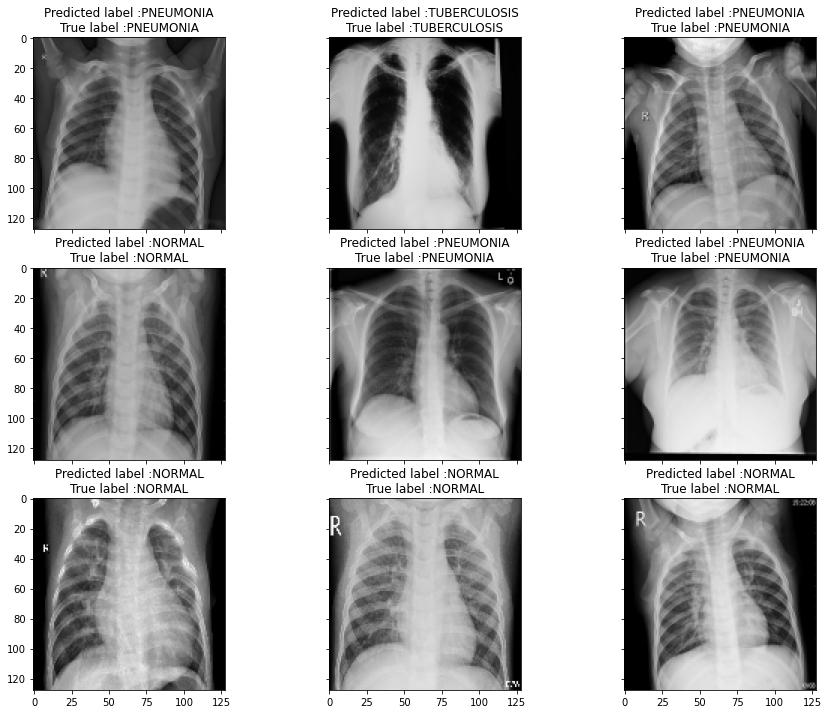

In [18]:
label=['PNEUMONIA', 'NORMAL', 'TUBERCULOSIS']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Confusion Matrix

Text(0.5, 145.31999999999996, 'Predicted')

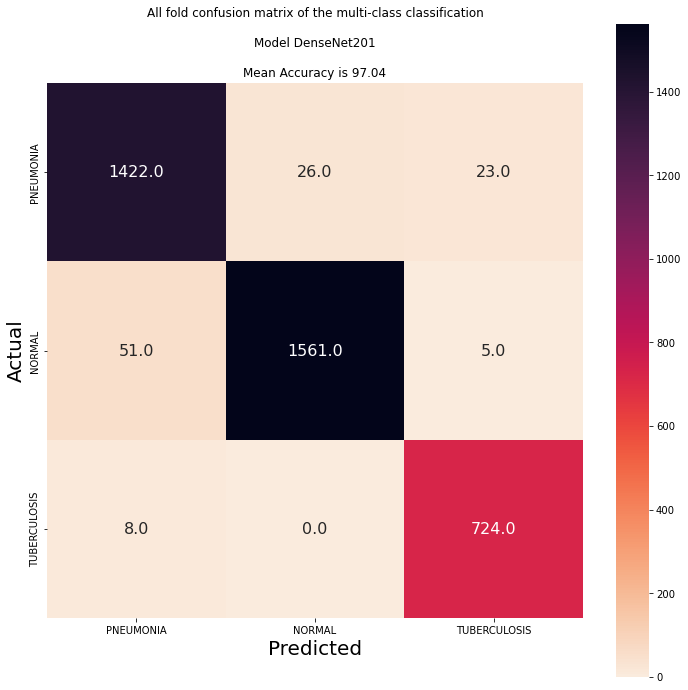

In [20]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title('All fold confusion matrix of the multi-class classification\n\nModel DenseNet201\n\nMean Accuracy is {:.2f}'
          .format((np.mean(results[1])*100)))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, 
                 annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [10]:
result = confusion_matrix(list(Ytrue), Ypred)
r = len(result)
C = [0,0,0,0,0,0,0,0,0]

In [29]:
k=0
for i in range(r):
    for j in range(r):
        C[k] = result[i][j]
        k += 1
#TP = True Positive FP = Flase Positive
TP1 = C[0]
TP2 = C[4]
TP3 = C[8]
print("TP:")
print(TP1,TP2,TP3)
TP_AVG = (TP1+TP2+TP3)/3 
print(f'{TP_AVG:.2f}')
    #FP = Flase Positive
FP1 = C[3]+C[6]
FP2 = C[1]+C[7]
FP3 = C[2]+C[5]
print("FP:")
print(FP1,FP2,FP3)
FP_AVG = (FP1+FP2+FP3)/3 
print(f'{FP_AVG:.2f}')

    #FN = Flase Negative
FN1 = C[1]+C[2]
FN2 = C[3]+C[5]
FN3 = C[6]+C[7]
print("FN:")
print(FN1,FN2,FN3)
FN_AVG = (FN1+FN2+FN3)/3 
print(f'{FN_AVG:.2f}')
    #PC = Precision
PC1 = TP1/(TP1+FP1)
PC2 = TP2/(TP2+FP2) 
PC3 = TP3/(TP3+FP3)
    #RC = Recall
RC1 = TP1/(TP1+FN1) 
RC2 = TP2/(TP2+FN2)
RC3 = TP3/(TP3+FN3)
    #FS = f1_score = 2 x PC x RC / PC + RC
FS1 = 2*((PC1*RC1)/(PC1+RC1))
FS2 = 2*((PC2*RC2)/(PC2+RC2))
FS3 = 2*((PC3*RC3)/(PC3+RC3))

AVG_FS = (FS1+FS2+FS3)/3

TP:
1422 1561 724
1235.67
FP:
59 26 28
37.67
FN:
49 56 8
37.67


In [12]:
def show_metrics():
    p = [[PC1,RC1,FS1],
     [PC2,RC2,FS2],
     [PC3,RC3,FS3]]
    c = ['Precision','Recall','F1_score']
    index = ['PNEUMONIA', 'NORMAL', 'TUBERCULOSIS']
    table = pd.DataFrame(p,columns=c,index=index)
    print(table)

In [13]:
def show_metrics_AVG():
    AVG_PC = (PC1+PC2+PC3)/3
    AVG_RC = (RC1+RC2+RC3)/3
    AVG_FS = (FS1+FS2+FS3)/3
    p = [[AVG_PC,AVG_RC,AVG_FS]]
    c = ['AVG_Precision','AVG_Recall','AVG_F1_score']
    index = ['summary']
    table_AVG = pd.DataFrame(p,columns=c,index=index)
    print(table_AVG)

In [14]:
print('AVG f1_score =',AVG_FS)

AVG f1_score = 0.9711876217664829


In [15]:
show_metrics()

              Precision    Recall  F1_score
PNEUMONIA      0.960162  0.966689  0.963415
NORMAL         0.983617  0.965368  0.974407
TUBERCULOSIS   0.962766  0.989071  0.975741


In [16]:
show_metrics_AVG()

         AVG_Precision  AVG_Recall  AVG_F1_score
summary       0.968848    0.973709      0.971188
